# Adoption Prediction
build the best predictive  model for the next marketing
campaign,  i.e.,  for  predicting  likely  adopters  (that  is,  which  current  non -
                                                      subscribers  are  likely  to  respond  to  the  marketing  campaign and sign  up for
                                                      the  premium  service  within  6  months  after  the  campaign).
## Model Targets
- Beat f1 score: 0.1
- NN001 f1 score: 0.095

# Import Data

In [2]:
import pandas as pd
labeledData = pd.read_csv(r'../Data/LabelData.csv')
UnlabeledData = pd.read_csv(r'../Data/UnlabelData.csv')
labeledData.head(1)


,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
0,10,24,0,20,26.333333,0.777778,6,0,37804,4,...,0,54,0,0,0,0,79,0,0,0


# NN Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch


In [4]:
# Load the data
X = labeledData.drop(['adopter', 'user_id'], axis=1)
y = labeledData['adopter']

# Neural Network(NN) Model

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Neural Network model
def create_model():
    Dropout_Rate = 0.65
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


# NN Random Oversampling

545/545 [==============================] - 0s 616us/step
Run 1: F1 Score: 0.11444921316165953
545/545 [==============================] - 0s 600us/step
Run 2: F1 Score: 0.10244648318042812
545/545 [==============================] - 0s 596us/step
Run 3: F1 Score: 0.13202084539664158
545/545 [==============================] - 0s 600us/step
Run 4: F1 Score: 0.1071290944123314
545/545 [==============================] - 0s 601us/step
Run 5: F1 Score: 0.10311750599520383
Average F1 Score: 0.1118326284292529


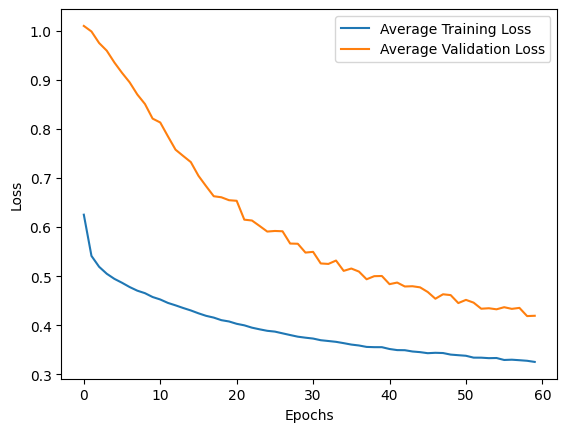

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=3, restore_best_weights=True)

f1_scores = []
training_losses = []
validation_losses = []

for i in range(5):
    # Apply RandomOverSampler to balance the training dataset
    ros = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

    # Clone the model
    model_1 = create_model()

    # Train the model
    history = model_1.fit(X_train_balanced, y_train_balanced,
                          epochs=60, batch_size=128,
                          verbose=0, callbacks=[early_stopping],
                          validation_split=0.3)
    # Evaluate the model
    y_pred = (model_1.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Run {i+1}: F1 Score: {f1}")
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    f1_scores.append(f1)

    if f1 < 0.085:
        print("Breaking the loop due to low F1 score.")
        break

average_f1 = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1}")

# Calculate the average training and validation losses over all runs
avg_training_loss = np.mean(training_losses, axis=0)
avg_validation_loss = np.mean(validation_losses, axis=0)

# Plot the average training and validation losses
plt.plot(avg_training_loss, label='Average Training Loss')
plt.plot(avg_validation_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# print(avg_training_loss, avg_validation_loss)
# Top record F1 Score: 0.13202084539664158
# Top Avg F1 Score: 0.09555316133087799
model_1.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               6656      
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)               